In [1]:
#Colab read data from google drive
import os
from google.colab import drive
drive.mount('/content/drive/')
import sys
sys.path.append('/content/drive/MyDrive/Pornpan(Eye)')

Mounted at /content/drive/


In [2]:
# Import libraries
import pandas as pd
import seaborn as sns
from olist.utils import *
import numpy as np
import statsmodels.formula.api as smf

In [3]:
# Import data
from olist.data import Olist
from olist.order import Order

In [4]:
data = Olist().get_data()
orders = Order().get_training_data()
matching_table = Olist().get_matching_table()

# Restricting customer states

In this notebook, we want to understand what the impact of preventing customers ordering products to certain states would be. To do so, let's run the following steps: 

- look at the share of one-star orders by state. 
- measure the cumulative share of one-star reviews and orders by state in descending order: this allows us to understand which state contributes the most to the overall share of one-star reviews.
- make an informed decision by outputing `review_score` impact and `orders` loss. 

### Merge orders with customer states

Our first step is to retrieve orders with customer state: 

In [5]:
# Merge to get order and customer_state in a DataFrame
mask_columns = ['order_id', 'customer_id']
order_customer = matching_table.drop_duplicates(subset=mask_columns)[mask_columns]
order_state = order_customer.merge(data['customers'], 
                                   on='customer_id')[['order_id', 'customer_state']]
orders = orders.merge(order_state, 
                      on='order_id')

### Compute cost and revenue at the order level

In [6]:
cost_mapping = {1:100, 2:50, 3:40, 4:0, 5:0}

In [7]:
orders['cost'] = orders['review_score'].map(cost_mapping)
orders['revenue'] = orders['price'] * 0.1

### Share of one-star reviews per state

We can then measure the share of one star orders per customer state. Observe how Rio de Janeiro state has 15% of orders as one-star reviews 😱

In [8]:
orders.groupby('customer_state')\
      .agg({'dim_is_one_star':'mean',
            'order_id':'count'})\
      .sort_values(by='dim_is_one_star', 
                   ascending=False).head()

,dim_is_one_star,order_id
customer_state,,
MA,0.156425,716
AL,0.153266,398
SE,0.152695,334
RJ,0.147871,12281
PA,0.144835,939


We can also plot the distribution of review_score by state: 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

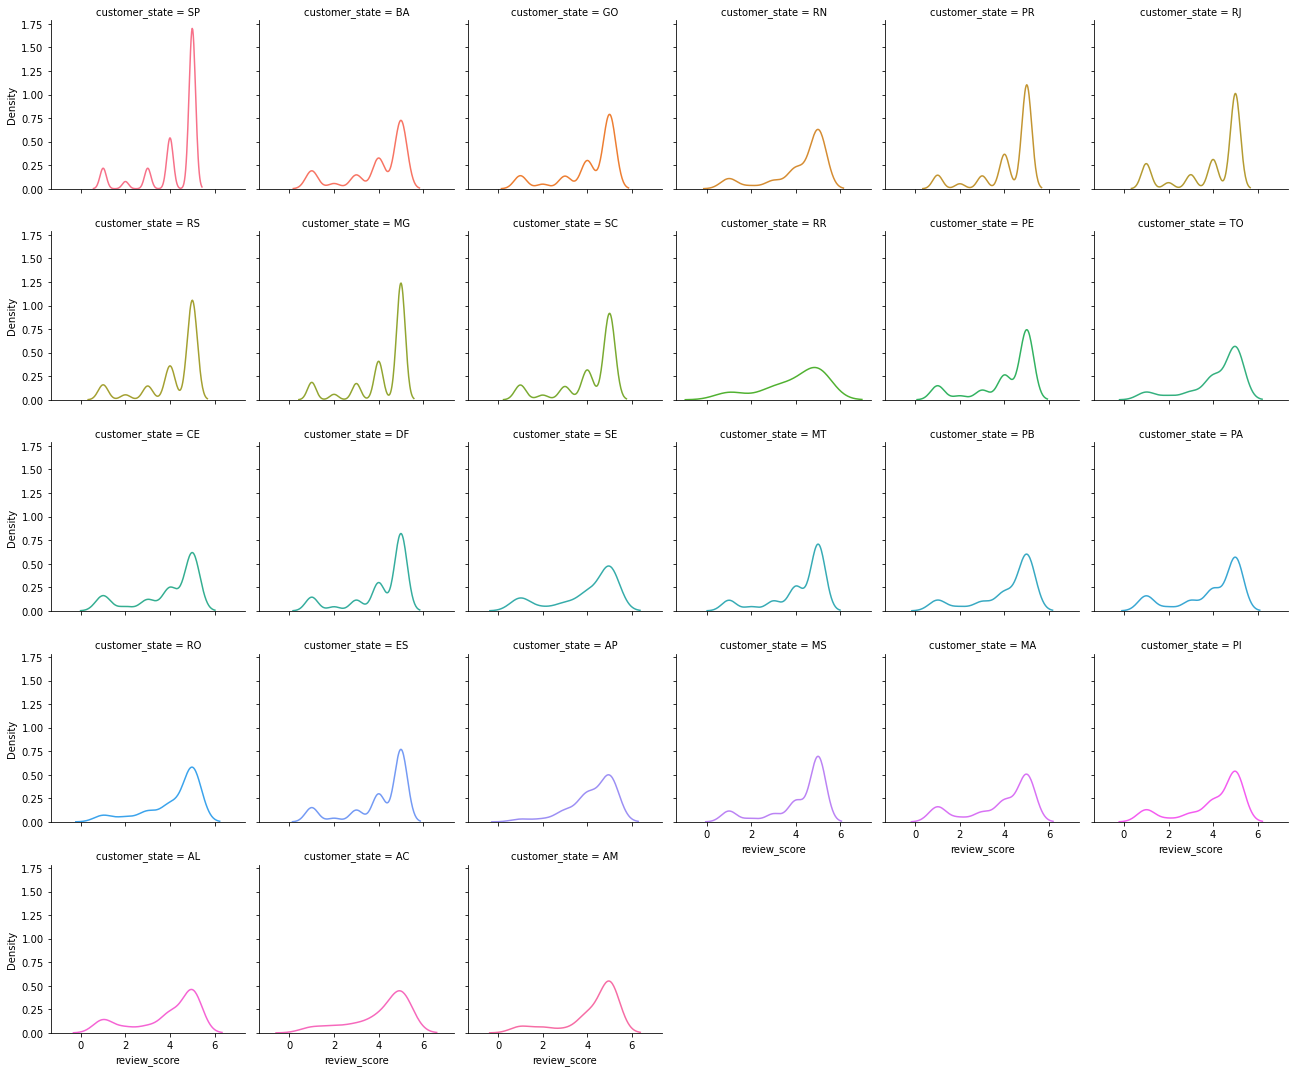

In [9]:
g = sns.FacetGrid(orders, col="customer_state", col_wrap=6, hue='customer_state')
g.map(sns.distplot, "review_score", hist=False);

### Cumulative share of cost, revenue and orders

We compute the cumulative share of cost in order to measure the contribution of each state.

In [ ]:
orders_agg = orders.groupby('customer_state')\
                   .agg({'cost':'sum',
                         'revenue':'sum',
                         'order_id':'count'})\
                   .sort_values(by='cost', 
                                ascending=False)

We then compute the metric `ratio` as the ratio of the `cost` to the `revenue`. A higher value means that a state contributes more to the `cost` than to the `revenue`:

In [ ]:
orders_agg['share_total_cost'] =\
    orders_agg['cost'] / orders_agg['cost'].sum()

orders_agg['share_total_revenue'] =\
    orders_agg['revenue'] / orders_agg['revenue'].sum()

orders_agg['ratio'] =\
    orders_agg['share_total_cost'] / orders_agg['share_total_revenue'] 

We then sort by this ratio and compute a **cumulative sum** on both orders and one-star orders: 

In [ ]:
orders_agg.sort_values(by='ratio', 
                       ascending=False, 
                       inplace=True)

In [1]:
orders_agg['cum_share_cost'] = orders_agg['cost'].cumsum() \
                                        / orders_agg['cost'].sum()

orders_agg['cum_share_revenue'] = orders_agg['revenue'].cumsum() \
                                        / orders_agg['revenue'].sum()

orders_agg['rank'] = orders_agg['cum_share_cost'].rank()

NameError: ignored

In [ ]:
orders_agg.head()

,cost,revenue,order_id,share_total_cost,share_total_revenue,ratio,cum_share_cost,cum_share_revenue,rank
customer_state,,,,,,,,,
RJ,251710,176019.596,12370,0.174613,0.133170,1.311208,0.174613,0.133170,1.0
MA,15700,11630.977,717,0.010891,0.008800,1.237700,0.185504,0.141969,2.0
BA,64210,49325.287,3256,0.044543,0.037318,1.193617,0.230047,0.179287,3.0
ES,33690,26776.731,1991,0.023371,0.020258,1.153654,0.253418,0.199545,4.0
SE,6920,5648.429,334,0.004800,0.004273,1.123338,0.258219,0.203818,5.0


Plot those two curves on a graph: 

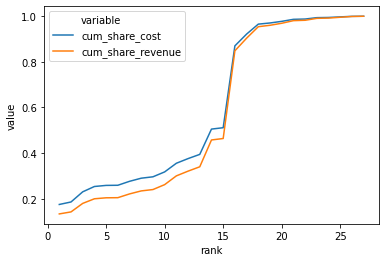

In [ ]:
orders_agg_melt = orders_agg[['rank', 
                          'cum_share_cost', 
                          'cum_share_revenue']].melt(id_vars=['rank'], 
                                                    value_vars=['cum_share_cost', 
                                                                'cum_share_revenue'])
ax = sns.lineplot(x="rank", 
                  y="value", 
                  hue="variable", 
                  data=orders_agg_melt)

The plot and the table above let us see that Rio de Janerio alone contributes 17% of the cost and 13% of the revenue.

### Simulation table

In this last part we simulate the impact of removing top states on the overall review_score and share_one star: 

In [ ]:
def recompute_metrics(rank):
    list_states = orders_agg[orders_agg['rank'] <= rank].index.to_list()
    df = orders.query("customer_state!="+str(list_states))
    review_score = df['review_score'].mean()
    n_orders = df.shape[0]
    orders_impact =  n_orders - orders.shape[0]
    share_one_star = df['dim_is_one_star'].sum() / n_orders
    margin_ratio = df['revenue'].sum() / df['cost'].sum()
    return {'rank':rank,
            'states_removed':str(list_states),
            'review_score':review_score,
            'share_one_star':share_one_star,
            'orders_impact':orders_impact,
            'margin_ratio':margin_ratio}

In [ ]:
a = {}
for i in np.arange(0,7):
    a[i] = recompute_metrics(i)

In [ ]:
pd.DataFrame(a).T

,rank,states_removed,review_score,share_one_star,orders_impact,margin_ratio
0,0,[],4.142,0.100596,0,0.916921
1,1,['RJ'],4.17098,0.0930545,-12370,0.962961
2,2,"['RJ', 'MA']",4.1739,0.0924878,-13087,0.965931
3,3,"['RJ', 'MA', 'BA']",4.18475,0.0906812,-16343,0.977371
4,4,"['RJ', 'MA', 'BA', 'ES']",4.18832,0.089972,-18334,0.983086
5,5,"['RJ', 'MA', 'BA', 'ES', 'SE']",4.18955,0.0896901,-18668,0.984166
6,6,"['RJ', 'MA', 'BA', 'ES', 'SE', 'RR']",4.1897,0.0896731,-18709,0.98427


_Note_: if Olist were to stop selling in `RJ`, this would: 
- Increase review score to 4.17
- Bring share of one star reviews below 10% 
- Reach a 1.92 margin ratio 
- Come at the cost of 12k orders 